In [ ]:
import matplotlib.pyplot as plt
import gzip
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from __future__ import annotations

## Read in the data

In [ ]:
# ---------- CONFIG ----------
### CHANGE THE PATH BEFORE YOU WANT TO RUN IT
DATA_DIR = Path("data") 
LABELS_PATH = DATA_DIR / "data.info.labelled" 
DATASET_PATH = DATA_DIR / "dataset0.json.gz"
OUT_CSV = DATA_DIR / "features_dataset0.csv"

# Minimum reads to keep a site (set to 1 to keep all)
MIN_READS = 1

# ---------- HELPERS ----------

def is_drach(center_5mer: str) -> bool:
    """Return True if 5-mer matches DRACH (D=[A/G/T], R=[A/G], A, C, H=[A/C/T])."""
    if len(center_5mer) != 5:
        return False
    D = set("AGT")
    R = set("AG")
    H = set("ACT")
    c = center_5mer.upper()
    return (c[0] in D) and (c[1] in R) and (c[2] == "A") and (c[3] == "C") and (c[4] in H)


def parse_record(line: str):
    """
    Parse one JSONL line with structure:
      {transcript_id: {position: {heptamer: [[9 features], ...] } } }
    Return tuple:
      (transcript_id:str, position:int, heptamer:str, reads:list[list[float]])
    Raise ValueError if structure invalid.
    """
    obj = json.loads(line)

    if not isinstance(obj, dict) or len(obj) != 1:
        raise ValueError("Top-level must be a dict with exactly one transcript_id key")

    transcript_id, inner1 = next(iter(obj.items()))
    if not isinstance(inner1, dict) or len(inner1) != 1:
        raise ValueError("Second level must be a dict with exactly one position key")

    position_str, inner2 = next(iter(inner1.items()))
    try:
        position = int(position_str)
    except Exception as e:
        raise ValueError(f"Position key must be int-convertible, got: {position_str}") from e

    if not isinstance(inner2, dict) or len(inner2) != 1:
        raise ValueError("Third level must be a dict with exactly one heptamer key")

    heptamer, reads = next(iter(inner2.items()))
    if not isinstance(heptamer, str) or len(heptamer) < 5:
        raise ValueError(f"Heptamer must be a string (len>=5), got: {heptamer}")

    if not isinstance(reads, list):
        raise ValueError("Reads must be a list of lists with 9 numeric features each")

    # Basic read shape validation (allow empty list; we'll filter later)
    for r in reads[:5]:  # spot-check first few to avoid heavy cost on huge sites
        if not (isinstance(r, list) and len(r) == 9 and all(isinstance(x, (int, float)) for x in r)):
            raise ValueError("Each read must be a list of 9 numeric features")

    return transcript_id, position, heptamer, reads


def robust_quantiles(arr: np.ndarray, qs=(0.25, 0.75)):
    """Return quantiles as a tuple for given probabilities."""
    if arr.size == 0:
        return (np.nan,) * len(qs)
    return tuple(np.quantile(arr, q) for q in qs)


def aggregate_reads(reads):
    """
    Given list of reads [[9 features]...], return dict of aggregated stats.
    Stats per base feature (9 of them): mean, std, median, q25, q75, iqr, min, max
    """
    arr = np.asarray(reads, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 9:
        raise ValueError("Reads array must be N x 9")

    stats = {}
    # Name the 9 base features
    base_names = [
        "m1_dt", "m1_sd", "m1_mean",
        "c_dt", "c_sd", "c_mean",
        "p1_dt", "p1_sd", "p1_mean",
    ]

    for j, feat in enumerate(base_names):
        col = arr[:, j]
        # Clean inf/nan
        col = col[np.isfinite(col)]
        if col.size == 0:
            # If all invalid, fill with nan
            stats[f"{feat}_mean"] = np.nan
            stats[f"{feat}_std"] = np.nan
            stats[f"{feat}_median"] = np.nan
            stats[f"{feat}_q25"] = np.nan
            stats[f"{feat}_q75"] = np.nan
            stats[f"{feat}_iqr"] = np.nan
            stats[f"{feat}_min"] = np.nan
            stats[f"{feat}_max"] = np.nan
            continue

        q25, q75 = robust_quantiles(col, (0.25, 0.75))
        stats.update({
            f"{feat}_mean": float(np.mean(col)),
            f"{feat}_std": float(np.std(col, ddof=1)) if col.size > 1 else 0.0,
            f"{feat}_median": float(np.median(col)),
            f"{feat}_q25": float(q25),
            f"{feat}_q75": float(q75),
            f"{feat}_iqr": float(q75 - q25),
            f"{feat}_min": float(np.min(col)),
            f"{feat}_max": float(np.max(col)),
        })

    return stats


def load_labels(path: Path) -> pd.DataFrame:
    dtypes = {
        "gene_id": "string",
        "transcript_id": "string",
        "transcript_position": "int32",
        "label": "int8",
    }
    df = pd.read_csv(path, dtype=dtypes)
    # Ensure uniqueness on key; if duplicates exist, keep the first and warn.
    dup_mask = df.duplicated(subset=["transcript_id", "transcript_position"], keep=False)
    if dup_mask.any():
        n_dup = int(dup_mask.sum())
        print(f"[WARN] {n_dup} duplicate label rows on (transcript_id, transcript_position); keeping first per key.")
        df = df.drop_duplicates(subset=["transcript_id", "transcript_position"], keep="first")
    return df


# ---------- MAIN PIPELINE ----------

def main():
    # Load labels
    print("Loading labels...")
    df_info = load_labels(LABELS_PATH)
    print("df_info:", df_info.shape)

    # Prepare output CSV (streaming write)
    OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
    header_written = False

    n_lines = 0
    n_kept = 0
    n_skipped_empty = 0
    n_invalid = 0
    n_non_drach = 0

    with gzip.open(DATASET_PATH, "rt", encoding="utf-8") as f, open(OUT_CSV, "w", encoding="utf-8") as fout:
        for line in tqdm(f, desc="Processing dataset0.json.gz"):
            n_lines += 1
            line = line.strip()
            if not line:
                continue
            try:
                transcript_id, position, heptamer, reads = parse_record(line)
            except Exception as e:
                n_invalid += 1
                if n_invalid <= 5:
                    print(f"[WARN] Invalid record at line {n_lines}: {e}")
                continue

            if not reads or len(reads) < MIN_READS:
                n_skipped_empty += 1
                continue

            # Aggregate per-site
            stats = aggregate_reads(reads)
            n_reads = len(reads)

            # Central 5-mer is positions 2..6 of heptamer (0-based 1:6)
            center_5mer = heptamer[1:6] if len(heptamer) >= 6 else heptamer[:5]
            drach_flag = is_drach(center_5mer)
            if not drach_flag:
                n_non_drach += 1  # informative; per spec it should be DRACH

            row = {
                "transcript_id": transcript_id,
                "transcript_position": position,
                "heptamer": heptamer,
                "center_5mer": center_5mer,
                "is_drach": int(drach_flag),
                "n_reads": n_reads,
                **stats,
            }

            # Attach label if present
            # (fast lookup via merge-on-write: small single-row DataFrame join)
            lbl = labels_map.get((str(transcript_id), int(position)))
            row["label"] = lbl if lbl is not None else pd.NA

            # Stream-write row
            row_df = pd.DataFrame([row])
            if not header_written:
                row_df.to_csv(fout, index=False)
                header_written = True
            else:
                row_df.to_csv(fout, index=False, header=False)
            n_kept += 1

    print("\nDone.")
    print(f" Total lines read:        {n_lines}")
    print(f" Kept (with >= {MIN_READS} reads): {n_kept}")
    print(f" Skipped (empty/low cov): {n_skipped_empty}")
    print(f" Invalid structure:       {n_invalid}")
    print(f" Non-DRACH centers:       {n_non_drach}")
    print(f" Wrote features to:       {OUT_CSV}")


if __name__ == "__main__":
    main()


Loading labels...
df_info: (121838, 4)


Processing dataset0.json.gz: 121838it [04:26, 457.44it/s]


Done.
 Total lines read:        121838
 Kept (with >= 1 reads): 121838
 Skipped (empty/low cov): 0
 Invalid structure:       0
 Non-DRACH centers:       0
 Wrote features to:       data\features_dataset0.csv


## EDA

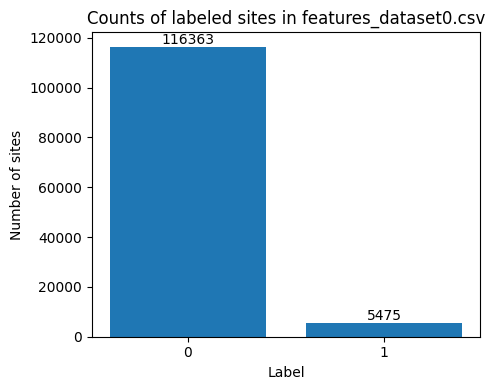

In [3]:
FEATURES_PATH = Path("data/features_dataset0.csv")

df = pd.read_csv(FEATURES_PATH)

df = df[df["label"].isin([0, 1])].copy()

counts = df["label"].value_counts().sort_index()
counts_df = pd.DataFrame({
    "label": ["0", "1"],
    "count": [int(counts.get(0, 0)), int(counts.get(1, 0))],
})

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(counts_df["label"], counts_df["count"])
ax.set_title("Counts of labeled sites in features_dataset0.csv")
ax.set_xlabel("Label")
ax.set_ylabel("Number of sites")

for i, v in enumerate(counts_df["count"]):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

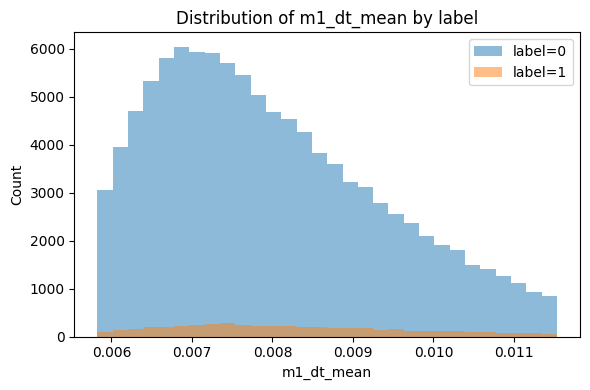

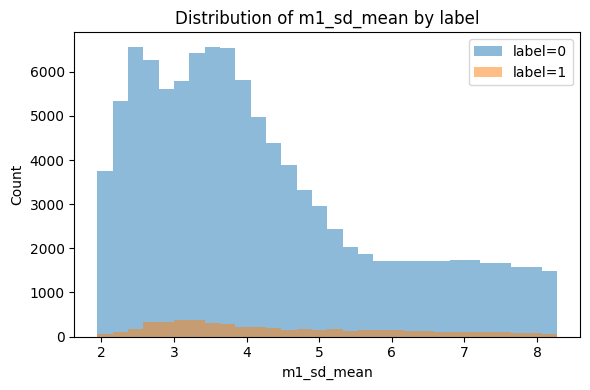

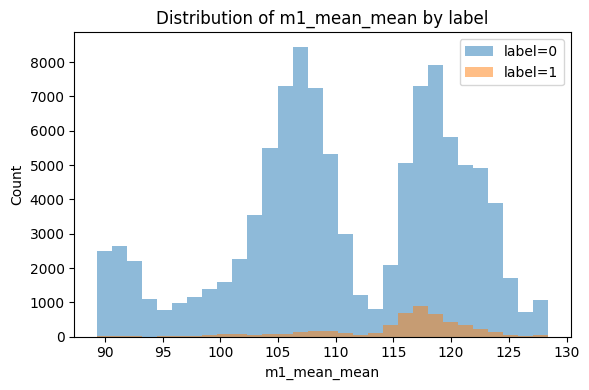

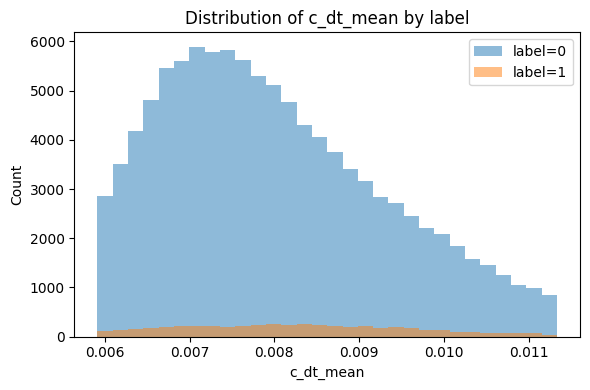

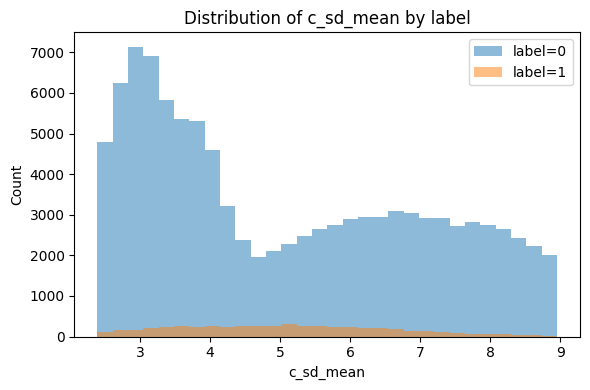

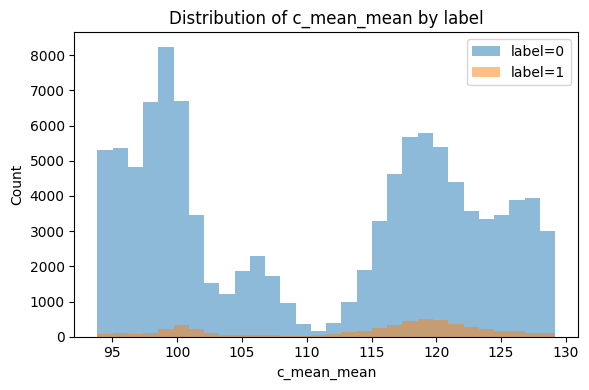

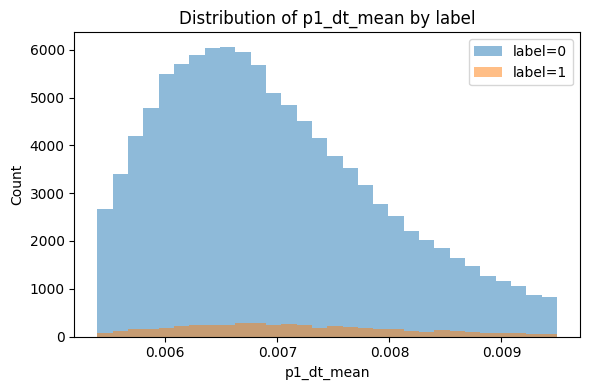

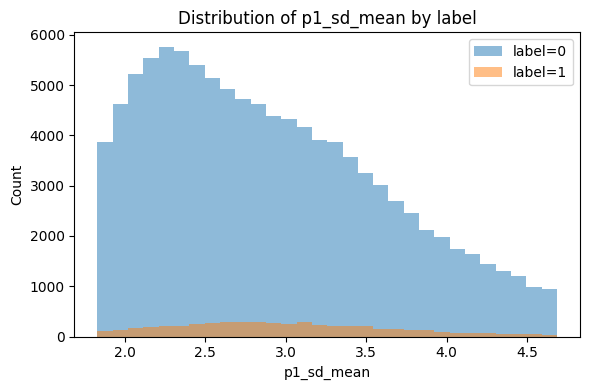

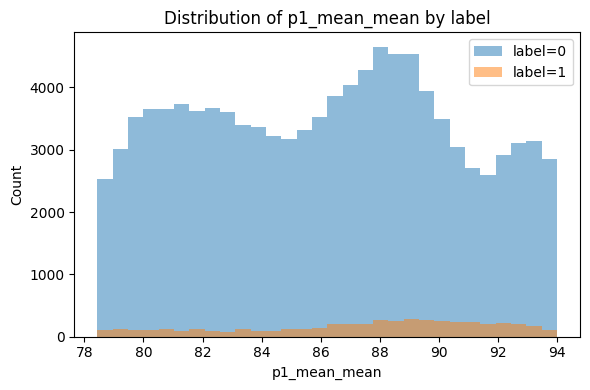

     feature  label  count       mean     median       std
   c_dt_mean      0 116363   0.008120   0.007819  0.001695
   c_dt_mean      1   5475   0.008278   0.008167  0.001634
 c_mean_mean      0 116363 110.761911 113.914286 12.539069
 c_mean_mean      1   5475 114.864291 118.100000  9.865094
   c_sd_mean      0 116363   5.161425   4.626129  2.208171
   c_sd_mean      1   5475   5.075140   5.012651  1.585414
  m1_dt_mean      0 116363   0.008094   0.007745  0.001782
  m1_dt_mean      1   5475   0.008405   0.008124  0.001850
m1_mean_mean      0 116363 110.541661 109.659468 11.375477
m1_mean_mean      1   5475 116.054781 117.206897  7.551773
  m1_sd_mean      0 116363   4.327787   3.824000  1.940280
  m1_sd_mean      1   5475   4.646910   4.174211  1.822596
  p1_dt_mean      0 116363   0.007046   0.006810  0.001295
  p1_dt_mean      1   5475   0.007283   0.007078  0.001301
p1_mean_mean      0 116363  86.173792  86.417840  4.936160
p1_mean_mean      1   5475  86.830278  87.964667  4.9209

In [4]:
base_feats = ["m1_dt","m1_sd","m1_mean","c_dt","c_sd","c_mean","p1_dt","p1_sd","p1_mean"]
stat_suffix = "_mean"

summary_rows = []
outdir = Path("eda_feature_dists")
outdir.mkdir(parents=True, exist_ok=True)

for base in base_feats:
    col = f"{base}{stat_suffix}"
    if col not in df.columns:
        print(f"[skip] {col} not found")
        continue

    d0 = df.loc[df["label"] == 0, col].replace([np.inf, -np.inf], np.nan).dropna()
    d1 = df.loc[df["label"] == 1, col].replace([np.inf, -np.inf], np.nan).dropna()

    # stats table
    for lbl, series in [(0, d0), (1, d1)]:
        mu = float(np.mean(series)) if len(series) else np.nan
        med = float(np.median(series)) if len(series) else np.nan
        sd = float(np.std(series, ddof=1)) if len(series) > 1 else (0.0 if len(series)==1 else np.nan)
        summary_rows.append({"feature": col, "label": lbl, "count": int(len(series)), "mean": mu, "median": med, "std": sd})

    # pick a robust plotting range to avoid extreme tails
    combined = pd.concat([d0, d1], axis=0)
    if len(combined) >= 10:
        lo, hi = np.quantile(combined, [0.05, 0.95])
        if lo == hi:
            lo, hi = combined.min(), combined.max()
    else:
        lo, hi = (combined.min() if len(combined) else 0.0, combined.max() if len(combined) else 1.0)

    fig, ax = plt.subplots(figsize=(6,4))
    if len(d0): ax.hist(d0, bins=30, alpha=0.5, range=(lo, hi), label="label=0")
    if len(d1): ax.hist(d1, bins=30, alpha=0.5, range=(lo, hi), label="label=1")
    ax.set_title(f"Distribution of {col} by label")
    ax.set_xlabel(col); ax.set_ylabel("Count")
    ax.legend()
    plt.tight_layout()
    plt.savefig(outdir / f"{col}_hist.png", dpi=150)
    plt.show()

summary_df = pd.DataFrame(summary_rows).sort_values(["feature","label"]).reset_index(drop=True)
print(summary_df.to_string(index=False))
summary_df.to_csv(outdir / "feature_distribution_summary.csv", index=False)
print(f"Saved figures and summary to: {outdir}")